In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyro-ppl

In [ ]:
import os
import random
from collections import Counter
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset,random_split,SubsetRandomSampler, WeightedRandomSampler
from tqdm import tqdm
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
def seed_everything(seed=3407):
    """
    Seed everything to make all operations in PyTorch (and other libraries) deterministic.
    Args:
        seed (int): Seed value to set.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x_cont = torch.tensor(self.dataframe.iloc[idx]['X_cont'], dtype=torch.float32)

        other_cols = self.dataframe.drop(columns=['label', 'X_cont','Unit1'])
        x_other = torch.tensor(other_cols.iloc[idx].values, dtype=torch.float32)

        label = torch.tensor(self.dataframe.iloc[idx]['label'], dtype=torch.long)

        return x_cont, x_other, label

In [ ]:
class BayesianCNN(nn.Module):
    def __init__(self, dyn_channels=5, stat_channels=32):
        super(BayesianCNN, self).__init__()

        self.conv1 = nn.Conv1d(dyn_channels, 10, kernel_size=4, padding=1) # 9
        self.bn1 = nn.BatchNorm1d(10)
        self.conv2 = nn.Conv1d(10, 20, kernel_size=4, padding=1) # 8
        self.bn2 = nn.BatchNorm1d(20)
        self.conv3 = nn.Conv1d(20, 30, kernel_size=4, padding=1) # 7
        self.bn3 = nn.BatchNorm1d(30)
        #self.conv4 = nn.Conv1d(30, 30, kernel_size=2, padding=1) # 6
        #self.bn4 = nn.BatchNorm1d(25)
        #nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        #nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        #nn.init.kaiming_normal_(self.conv3.weight, nonlinearity='relu')
        #nn.init.kaiming_normal_(self.conv4.weight, nonlinearity='relu')
        self.fc1 = nn.Linear(30*7, 30)
        self.fc2 = nn.Linear(30, 10)
        self.flatten = nn.Flatten()
        self.fc_static1 = nn.Linear(stat_channels, 25)
        self.fc_static2 = nn.Linear(25, 30)
        self.fc_static3 = nn.Linear(30, 10)
        self.softmax = nn.Softmax(-1)
        #self.bn5 = nn.BatchNorm1d(20)
        self.fc_final1 = nn.Linear(20, 10)
        #self.bn6 = nn.BatchNorm1d(10)
        self.fc_final2 = nn.Linear(10,2)
        #self.log_softmax = nn.LogSoftmax(dim=1)
        #nn.init.xavier_normal_(self.fc1.weight)
        #nn.init.xavier_normal_(self.fc2.weight)
        #nn.init.xavier_normal_(self.fc_static1.weight)
        #nn.init.xavier_normal_(self.fc_static2.weight)
        #nn.init.xavier_normal_(self.fc_static3.weight)
        #nn.init.xavier_normal_(self.fc_final1.weight)
        #nn.init.xavier_normal_(self.fc_final2.weight)

    def forward(self, x_dynamic, x_static):

        x_dynamic = x_dynamic.permute(0,2,1)
        #print(f"the shape of x_dynamic after permutation is {x_dynamic.shape}")
        x = self.bn1(self.conv1(x_dynamic))
        x = torch.relu(x)
        x = self.bn2(self.conv2(x))
        x = torch.relu(x)
        x = self.bn3(self.conv3(x))
        #x = self.conv4(x)
        x = torch.relu(x)
        x = self.flatten(x)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        y = torch.relu(self.fc_static1(x_static))
        y = torch.relu(self.fc_static2(y))
        y = torch.relu(self.fc_static3(y))

        z = torch.cat((x, y), dim=1)
        z = self.fc_final2((torch.relu(self.fc_final1(z))))
        return z

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = BayesianCNN(dyn_channels=5, stat_channels=32).to(device)
net.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/pre_cnn.pth',map_location=torch.device('cpu')))
softmax = nn.Softmax(dim=1)

def model(x_dynamic, x_static, y=None):
        # Define prior distributions for all neural network weights
        '''
        fc_final1w_prior = dist.Normal(loc=torch.zeros_like(net.fc_final1.weight), scale=15*torch.ones_like(net.fc_final1.weight)).to_event(2)
        fc_final1b_prior = dist.Normal(loc=torch.zeros_like(net.fc_final1.bias), scale=15*torch.ones_like(net.fc_final1.bias)).to_event(1)'''
        fc_final2w_prior = dist.Normal(loc=torch.zeros_like(net.fc_final2.weight), scale=2.5*torch.ones_like(net.fc_final2.weight)).to_event(2)
        fc_final2b_prior = dist.Normal(loc=torch.zeros_like(net.fc_final2.bias), scale=0.4*torch.ones_like(net.fc_final2.bias)).to_event(1)


        model_priors = {
            #'fc_final1.weight': fc_final1w_prior, 'fc_final1.bias': fc_final1b_prior,
            'fc_final2.weight': fc_final2w_prior, 'fc_final2.bias': fc_final2b_prior,

        }
        lifted_module = pyro.random_module("module", net, model_priors)  # Lift module parameters to random variables
        lifted_reg_model = lifted_module()
        #with pyro.plate("data", x_dynamic.size(0)):
        lhat = softmax(lifted_reg_model(x_dynamic, x_static))
        if y is not None:
                y = y.float()
        pyro.sample("obs", dist.Categorical(logits=lhat).to_event(1), obs=y)


    # Defining the guide function for variational inference
def guide(x_dynamic, x_static, y=None):
        # Define variational distributions for the parameters (learnable)
        softplus = torch.nn.Softplus()
        '''
        fc_final1w_mu = torch.randn_like(net.fc_final1.weight)
        fc_final1w_sigma = torch.randn_like(net.fc_final1.weight)
        fc_final1w_mu_param = pyro.param("fc_final1w_mu", fc_final1w_mu)
        fc_final1w_sigma_param = softplus(pyro.param("fc_final1w_sigma", fc_final1w_sigma))
        fc_final1w_prior = dist.Normal(loc=fc_final1w_mu_param, scale=fc_final1w_sigma_param).to_event(2)
        fc_final1b_mu = torch.randn_like(net.fc_final1.bias)
        fc_final1b_sigma = torch.randn_like(net.fc_final1.bias)
        fc_final1b_mu_param = pyro.param("fc_final1b_mu", fc_final1b_mu)
        fc_final1b_sigma_param = softplus(pyro.param("fc_final1b_sigma", fc_final1b_sigma))
        fc_final1b_prior = dist.Normal(loc=fc_final1b_mu_param, scale=fc_final1b_sigma_param).to_event(1)
'''
        fc_final2w_mu = torch.randn_like(net.fc_final2.weight)
        fc_final2w_sigma = torch.randn_like(net.fc_final2.weight)
        fc_final2w_mu_param = pyro.param("fc_final2w_mu", fc_final2w_mu)
        fc_final2w_sigma_param = softplus(pyro.param("fc_final2w_sigma", fc_final2w_sigma))
        fc_final2w_prior = dist.Normal(loc=fc_final2w_mu_param, scale=fc_final2w_sigma_param).to_event(2)
        fc_final2b_mu = torch.randn_like(net.fc_final2.bias)
        fc_final2b_sigma = torch.randn_like(net.fc_final2.bias)
        fc_final2b_mu_param = pyro.param("fc_final2b_mu", fc_final2b_mu)
        fc_final2b_sigma_param = softplus(pyro.param("fc_final2b_sigma", fc_final2b_sigma))
        fc_final2b_prior = dist.Normal(loc=fc_final2b_mu_param, scale=fc_final2b_sigma_param).to_event(1)


        guide_priors = {
                  #'fc_final1.weight': fc_final1w_prior, 'fc_final1.bias': fc_final1b_prior,
                  'fc_final2.weight': fc_final2w_prior, 'fc_final2.bias': fc_final2b_prior,
                  }
        lifted_module = pyro.random_module("module", net, guide_priors)  # Lift module parameters to random variables
        return lifted_module()

In [ ]:
trainval_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/train.pkl').reset_index(drop=True)

class_0 = trainval_df[trainval_df['label'] == 0]
class_1 = trainval_df[trainval_df['label'] == 1]
n_samples = len(class_1)
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
train_df = df_balanced.reset_index(drop=True)

N = len(train_df)
train_df = train_df.sample(frac=1).reset_index(drop=True)
val = train_df[:int(N*0.2)]
train_df = train_df[int(N*0.2):]
train_df.fillna(value=np.pi, inplace=True)
val.fillna(value=np.pi, inplace=True)

In [ ]:
print(train_df.shape)
print(val.shape)

(28245, 35)
(7061, 35)


In [ ]:
train_dataset = SequenceDataset(train_df)
valid_dataset = SequenceDataset(val)
train_num = len(train_dataset)
val_num = len(valid_dataset)
batch_size=20
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw, drop_last=True)

print("using {} samples for training, {} samples for validation.".format(train_num,
                                                                           val_num))

Using 2 dataloader workers every process
using 28245 samples for training, 7061 samples for validation.


In [ ]:
sample = train_dataset[0]
print(sample[0].shape)
print(sample[1].shape)
print(sample[2])
for x_dynamic, x_static, y in train_loader:
    print(x_dynamic.shape)
    print(x_static.shape)
    print(y.shape)
    break

torch.Size([10, 5])
torch.Size([32])
tensor(0)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([20, 10, 5])
torch.Size([20, 32])
torch.Size([20])


In [ ]:
num_samples = 6
def predict(x_dynamic, x_static):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x_dynamic, x_static).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    #print(mean.numpy())
    return np.argmax(mean.cpu().numpy(), axis=1)#(mean > 0.5).float().reshape(-1)

In [ ]:
def train(model, guide, train_loader, valid_loader, num_epochs=30):

    optim = Adam({"lr": 5e-4})
    svi = SVI(model, guide, optim, loss=Trace_ELBO())
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []

    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total_train = 0
        for x_dynamic, x_static, y in train_loader:

            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            #print(x_dynamic.shape)
            loss = svi.step(x_dynamic, x_static, y)
            total_loss += loss

            with torch.no_grad():
                #lifted_module = model.guide(x_dynamic, x_static, y)
                pred_label = predict(x_dynamic, x_static)
                #print(f"the prediction prob is:{pred.reshape(-1)}")
                #pred = torch.sigmoid(pred)
            #pred_label = (pred > 0.5).float()
            #print(f"the prediction labels is:{pred_label.reshape(-1)}")
            correct += (pred_label.reshape(-1) == y.cpu().numpy().reshape(-1)).astype(int).sum().item()
            total_train += y.shape[0]
            #print(pred_label.reshape(-1))
            #print(y.shape[0])
        epoch_loss = total_loss / total_train
        epoch_accuracy = correct / total_train
        train_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}")
        train_loss_list.append(epoch_loss)

        total_loss = 0
        correct = 0
        total = 0
        for x_dynamic, x_static, y_val in valid_loader:

            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y_val = y_val.cuda()
            with torch.no_grad():
                loss = svi.evaluate_loss(x_dynamic, x_static, y_val)
                total_loss += loss
                #lifted_module = model.guide(x_dynamic, x_static, y)
                pred_label = predict(x_dynamic, x_static)
                #print(pred)
                #pred = torch.sigmoid(pred)
                #pred_label = (pred > 0.5).float()
                total += y_val.shape[0]
                correct += (pred_label.reshape(-1) == y_val.cpu().numpy().reshape(-1)).astype(int).sum().item()

            epoch_loss = total_loss / total
        epoch_accuracy = correct / total
        valid_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss}, Validation Accuracy: {epoch_accuracy}")
        valid_loss_list.append(epoch_loss)
    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [ ]:
print(len(train_loader))

1412


In [ ]:
#model = BayesianCNN(dyn_channels=5, stat_channels=32)
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(model, guide, train_loader, valid_loader, num_epochs=30)

/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


Epoch 1, Train Loss: 55.2936077674835, Train Accuracy: 0.5038951841359773
Epoch 1, Validation Loss: 59.28003409658545, Validation Accuracy: 0.5130311614730878
Epoch 2, Train Loss: 54.29739349452151, Train Accuracy: 0.5112606232294618
Epoch 2, Validation Loss: 53.01327061099304, Validation Accuracy: 0.5271954674220963
Epoch 3, Train Loss: 49.25146661373568, Train Accuracy: 0.5343838526912181
Epoch 3, Validation Loss: 49.13700857027394, Validation Accuracy: 0.5495750708215298
Epoch 4, Train Loss: 47.404917766508404, Train Accuracy: 0.5436260623229462
Epoch 4, Validation Loss: 45.05436091814771, Validation Accuracy: 0.5575070821529745
Epoch 5, Train Loss: 41.583761057527816, Train Accuracy: 0.5552762039660056
Epoch 5, Validation Loss: 42.26848667242034, Validation Accuracy: 0.5686968838526912
Epoch 6, Train Loss: 40.44030810149423, Train Accuracy: 0.5618626062322947
Epoch 6, Validation Loss: 38.759897001336725, Validation Accuracy: 0.5736543909348442
Epoch 7, Train Loss: 37.51586761056490

Text(0.5, 1.0, 'Accuracy curve')

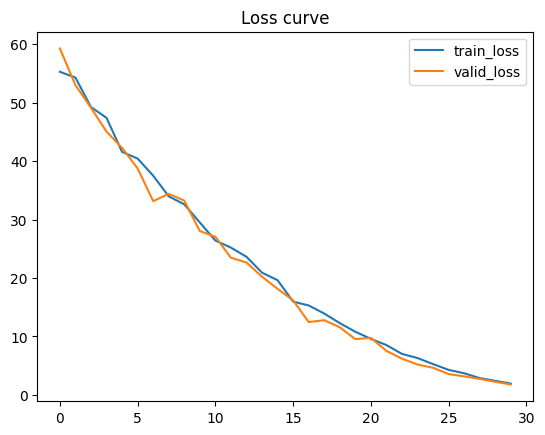

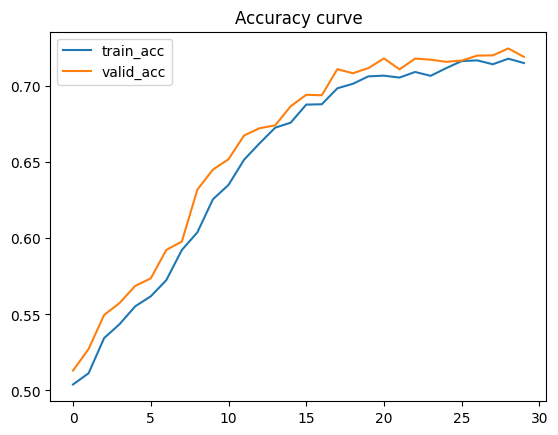

In [ ]:
plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(valid_loss_list, label="valid_loss")
plt.legend()
plt.title(f"Loss curve")

plt.figure()
plt.plot(train_acc_list, label="train_acc")
plt.plot(valid_acc_list, label="valid_acc")
plt.legend()
plt.title(f"Accuracy curve")

In [ ]:
batch_size=20
test_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/test.pkl').reset_index(drop=True)

class_0 = test_df[test_df['label'] == 0]
class_1 = test_df[test_df['label'] == 1]
n_samples = len(class_1)
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
test_df = df_balanced.reset_index(drop=True)

N = len(test_df)
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df.fillna(value=np.pi, inplace=True)
test_dataset = SequenceDataset(test_df)
test_num = len(test_dataset)


test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = False)

In [ ]:
correct = 0
total = 0
y_true=[]
y_pred=[]
for x_dynamic, x_static, y in test_loader:

            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            y = y.float()
            with torch.no_grad():
                lifted_module = guide(x_dynamic, x_static, y)
                pred_label = predict(x_dynamic, x_static)
                total += y.shape[0]
                correct += (pred_label.reshape(-1) == y.cpu().numpy().reshape(-1)).astype(int).sum().item()
                y_true.append(y.cpu().reshape(-1))
                y_pred.append(pred_label.reshape(-1))

print(f"the test accuracy is {correct/total}")

the test accuracy is 0.7021988527724665


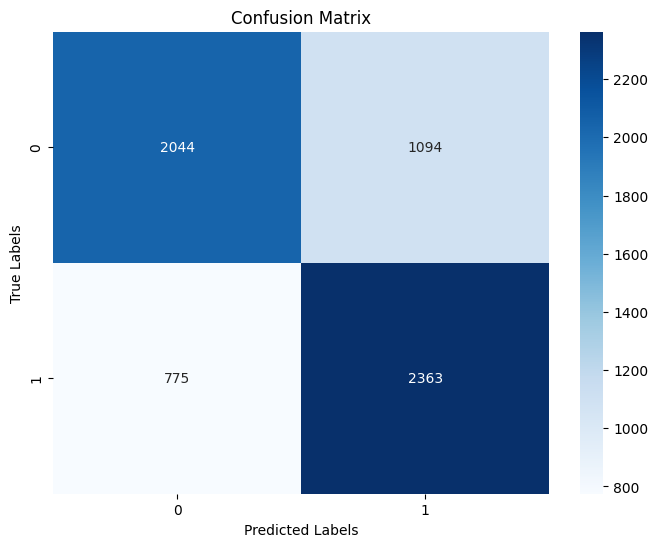

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import seaborn as sns
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
CM = confusion_matrix(y_true, y_pred)
#auc_score = roc_auc_score(y_true, y_prob_list, multi_class='ovr')
plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot=True, fmt="d", cmap='Blues')#, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
torch.save(pyro.get_param_store().get_state(), '/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/bayesian_pre_cnn.pth')

In [ ]:
for name, value in pyro.get_param_store().items():
    print(f"Parameter Name: {name}")
    print(f"Values:\n{value}\n")

Parameter Name: fc_final1w_mu
Values:
tensor([[-1.2413e-01,  6.4486e-02,  6.7973e-02,  1.0013e+00,  5.7517e-02,
          1.1289e-01, -2.9523e-02, -1.0692e-02,  4.4175e-02,  3.1904e-02,
         -2.7265e-02,  4.2978e-01,  2.9295e-02,  8.9411e-01, -5.6290e-02,
         -2.7284e-01, -5.3072e-02, -5.7123e-02,  4.6764e-02,  2.9568e-02],
        [-1.0981e-01,  1.0741e-01, -1.3661e-02, -6.7755e-01, -9.8950e-02,
         -6.8795e-02, -6.1128e-02, -4.8305e-02, -4.6794e-02, -6.7715e-02,
         -1.7373e-03, -8.1454e-02, -1.1582e-01, -1.4002e+00,  9.1559e-02,
         -5.9470e-01,  6.5698e-03,  5.0752e-03, -2.3327e-02,  2.2267e-02],
        [-4.9796e-03, -2.3907e-02, -2.3081e-03, -5.4612e-03,  5.6442e-03,
          4.7321e-02, -1.0566e-01,  2.9078e-02, -9.0023e-02, -5.2913e-03,
          4.2308e-02,  3.3797e-02,  1.6428e-02,  4.1457e-01, -9.0477e-02,
         -1.3878e+00,  4.1083e-02, -1.5922e-02,  1.3654e-01,  1.3839e-02],
        [-6.7410e-02,  3.1039e-02,  5.7025e-02, -1.3984e+00,  6.9647e-0

In [ ]:
from torch.nn import functional as F
def predict_show(x_dynamic, x_static, num_samples):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.softmax(model(x_dynamic.cuda(), x_static.cuda())).cpu().data for model in sampled_models]
    print(yhats[0].shape)
    mean_list = torch.mean(torch.stack(yhats), 0)
    std_list = torch.std(torch.stack(yhats), 0)
    pred_list = np.argmax(mean_list.cpu().numpy(), axis=1)
    #print(mean.numpy())
    return mean_list, std_list, pred_list

<ipython-input-76-617822662ff8>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhats = [F.softmax(model(x_dynamic.cuda(), x_static.cuda())).cpu().data for model in sampled_models]


torch.Size([20, 2])


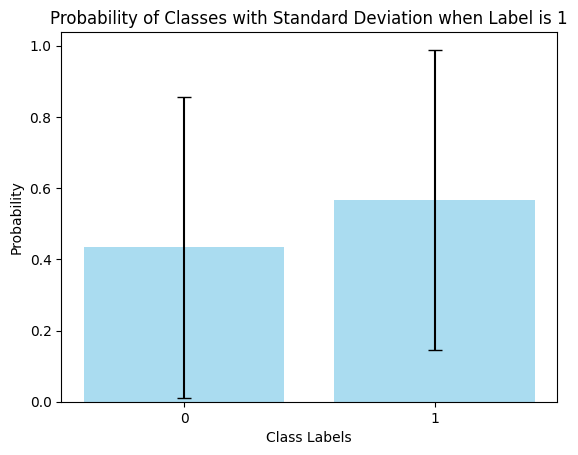

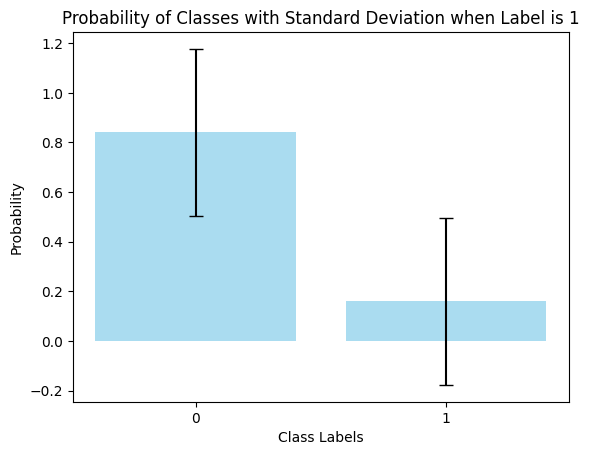

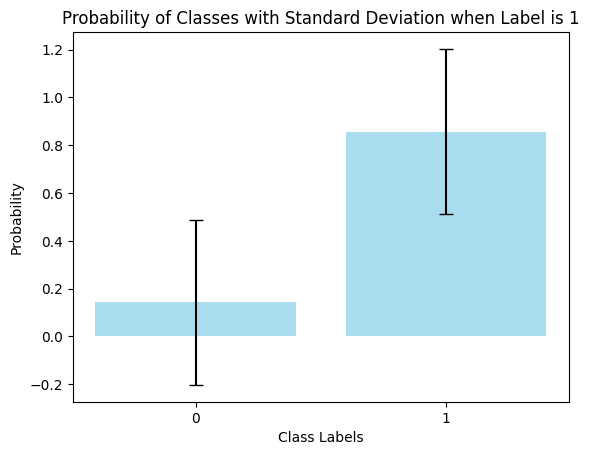

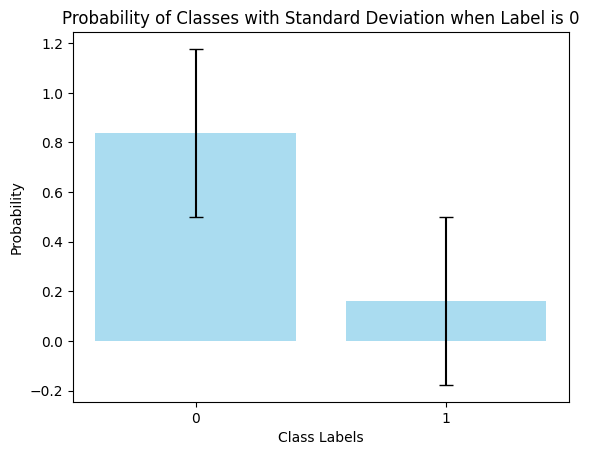

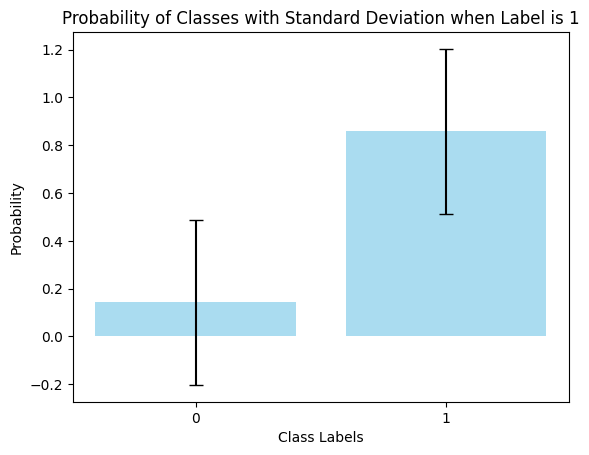

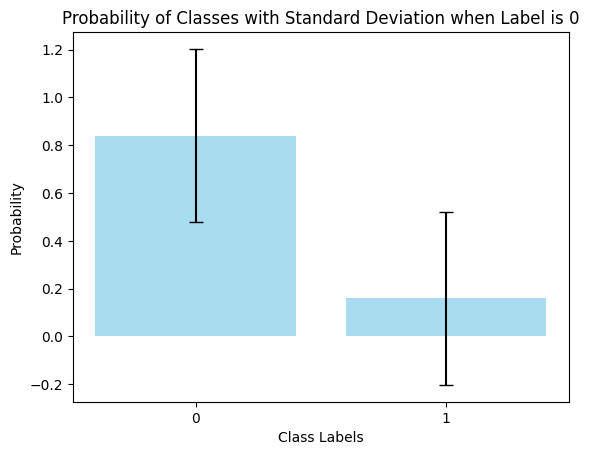

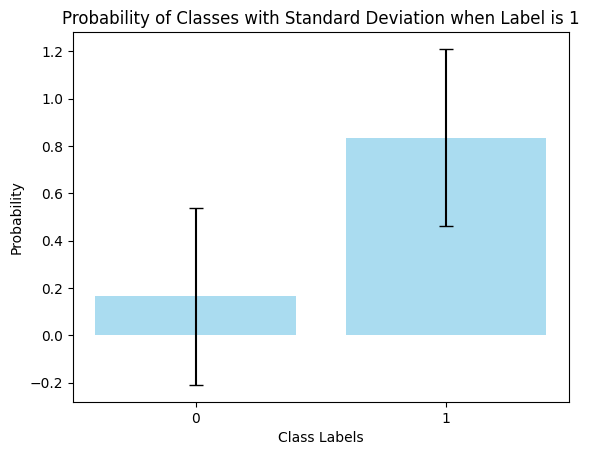

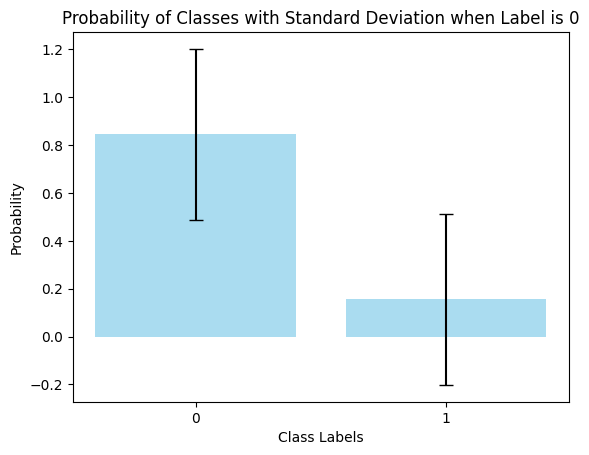

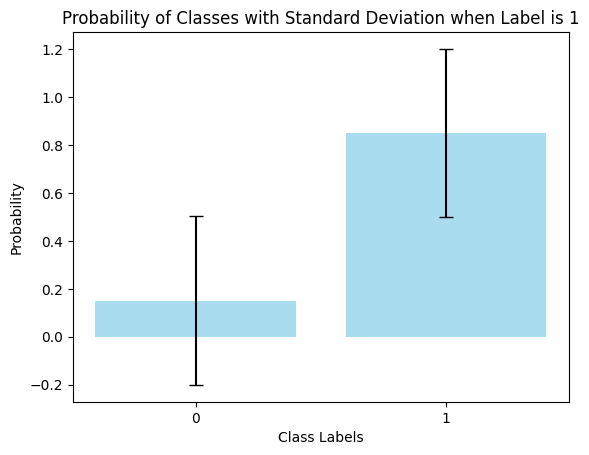

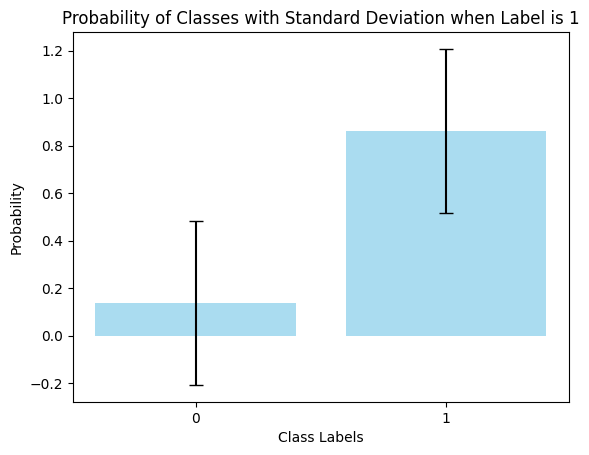

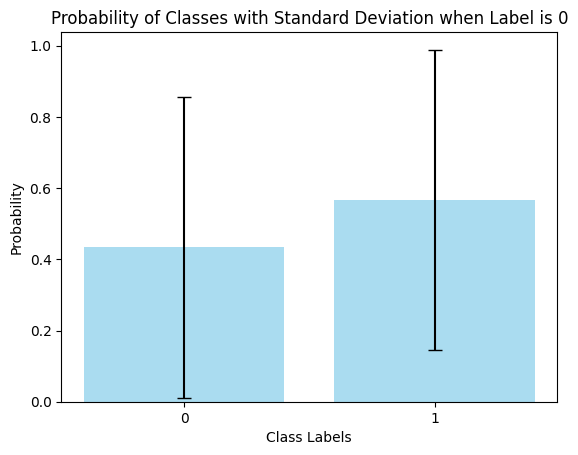

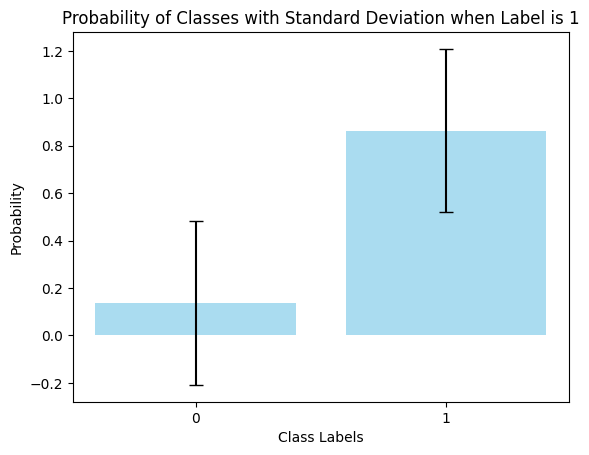

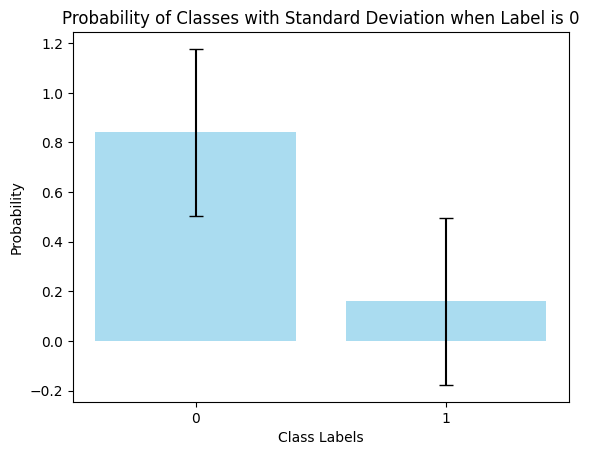

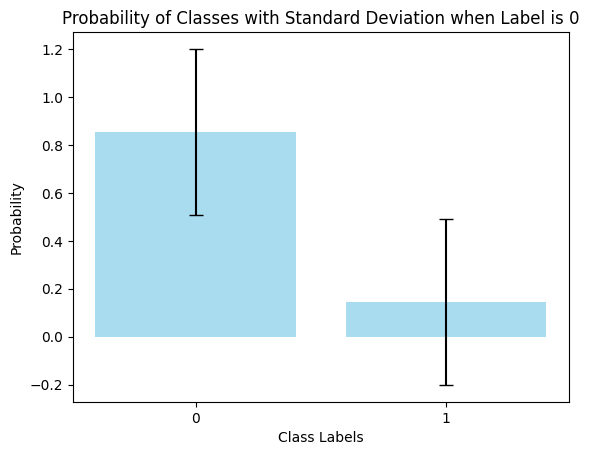

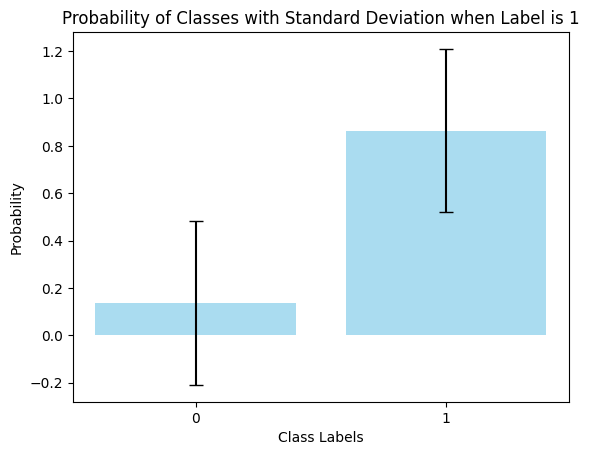

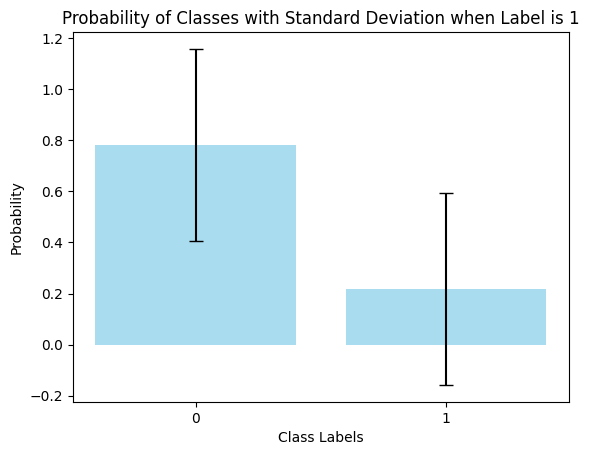

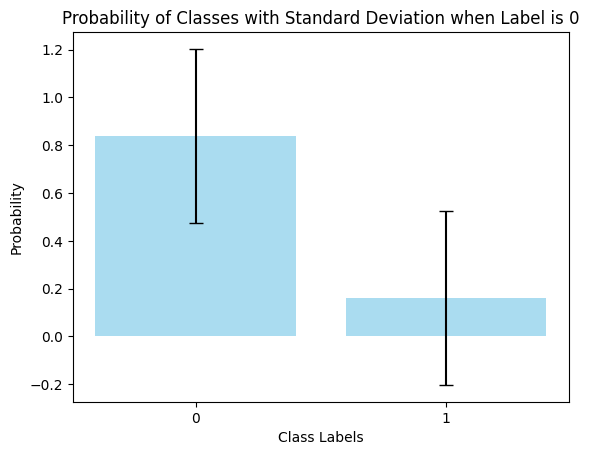

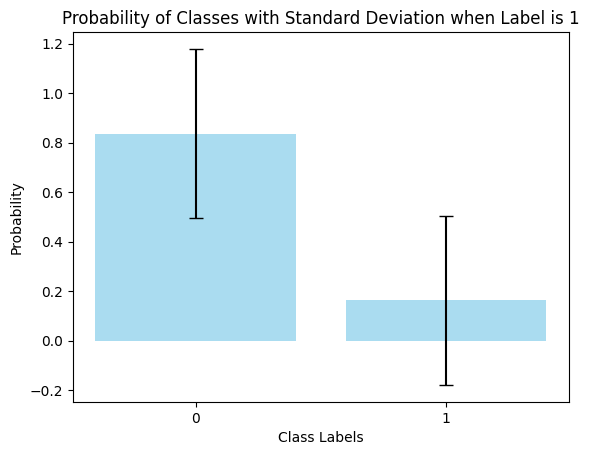

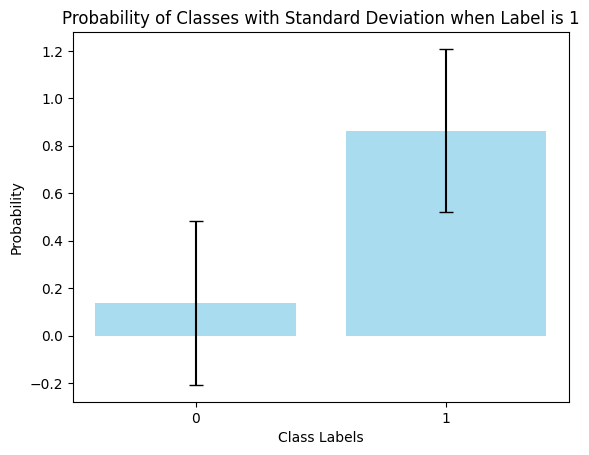

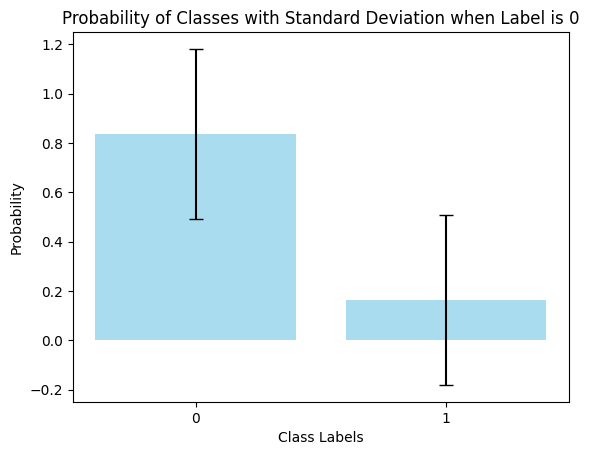

In [ ]:
for x_dynamic, x_static, y_val in valid_loader:
    mean_list, std_list, pred_list = predict_show(x_dynamic, x_static, 30)
    label_list = y_val
    break
for i in range(pred_list.shape[0]):
    means = mean_list[i]
    stds = std_list[i]
    preds = pred_list[i]
    label = label_list[i]
    plt.figure()
    plt.bar([0,1] , means, yerr=stds, capsize=5, color='skyblue', alpha=0.7)
    plt.xlabel('Class Labels')
    plt.ylabel('Probability')
    plt.title(f'Probability of Classes with Standard Deviation when Label is {label}')
    plt.xticks([0,1])  # Ensure x-ticks are only 0 and 1
    plt.show()